In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import re

2024-05-29 02:04:27.786090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 02:04:28.525096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
link_csv = 'HAM10000_metadata.csv'
generated_folder = 'generated'
skin_folder = 'Skin Cancer'

In [3]:
file_names = os.listdir(generated_folder)

nama_generated = []
for file_name in file_names:
    nama_generated.append(file_name)
print("Sukses Generated")

Sukses Generated


In [4]:
data_csv = pd.read_csv(link_csv)
data_csv = data_csv[['image_id', 'dx']]
data_csv

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [5]:
datas_generated = []

for generated_name in nama_generated:
    temp = re.search(r'ISIC_\d+', generated_name)
    if temp:
        result = temp.group(0)
        matching_row = data_csv[data_csv['image_id'] == result]
        if not matching_row.empty:
            dx_value = matching_row.iloc[0]['dx']
            datas_generated.append((generated_name, dx_value))
datas_generated

[('generated_ISIC_0028325.jpg', 'mel'),
 ('generated_ISIC_0030727.jpg', 'nv'),
 ('generated_ISIC_0031209.jpg', 'nv'),
 ('generated_ISIC_0024479.jpg', 'nv'),
 ('generated_ISIC_0027738.jpg', 'nv'),
 ('generated_ISIC_0027934.jpg', 'nv'),
 ('generated_ISIC_0032443.jpg', 'nv'),
 ('generated_ISIC_0025972.jpg', 'nv'),
 ('generated_ISIC_0026022.jpg', 'nv'),
 ('generated_ISIC_0031414.jpg', 'nv'),
 ('generated_ISIC_0031637.jpg', 'nv'),
 ('generated_ISIC_0027946.jpg', 'nv'),
 ('generated_ISIC_0034050.jpg', 'mel'),
 ('generated_ISIC_0027319.jpg', 'nv'),
 ('generated_ISIC_0033530.jpg', 'nv'),
 ('generated_ISIC_0025042.jpg', 'nv'),
 ('generated_ISIC_0029552.jpg', 'nv'),
 ('generated_ISIC_0025050.jpg', 'nv'),
 ('generated_ISIC_0024403.jpg', 'bcc'),
 ('generated_ISIC_0028576.jpg', 'nv'),
 ('generated_ISIC_0030952.jpg', 'nv'),
 ('generated_ISIC_0027574.jpg', 'nv'),
 ('generated_ISIC_0033169.jpg', 'bkl'),
 ('generated_ISIC_0034260.jpg', 'nv'),
 ('generated_ISIC_0032014.jpg', 'akiec'),
 ('generated_ISIC_

In [6]:
data_csv['image_id'] = data_csv['image_id'] + '.jpg'
data_csv

,image_id,dx
0,ISIC_0027419.jpg,bkl
1,ISIC_0025030.jpg,bkl
2,ISIC_0026769.jpg,bkl
3,ISIC_0025661.jpg,bkl
4,ISIC_0031633.jpg,bkl
...,...,...
10010,ISIC_0033084.jpg,akiec
10011,ISIC_0033550.jpg,akiec
10012,ISIC_0033536.jpg,akiec
10013,ISIC_0032854.jpg,akiec


In [7]:
len(datas_generated)

128

In [8]:
data_generated = pd.DataFrame(datas_generated, columns=['image_id', 'dx'])
data_generated

,image_id,dx
0,generated_ISIC_0028325.jpg,mel
1,generated_ISIC_0030727.jpg,nv
2,generated_ISIC_0031209.jpg,nv
3,generated_ISIC_0024479.jpg,nv
4,generated_ISIC_0027738.jpg,nv
...,...,...
123,generated_ISIC_0028802.jpg,nv
124,generated_ISIC_0032762.jpg,nv
125,generated_ISIC_0029287.jpg,nv
126,generated_ISIC_0033958.jpg,nv


In [9]:
total_kelas_generated = data_generated.groupby('dx').size().reset_index(name='total')
print(total_kelas_generated)

      dx  total
0  akiec      3
1    bcc      7
2    bkl     11
3     df      3
4    mel     10
5     nv     94


In [10]:
total_kelas_csv = data_csv.groupby('dx').size().reset_index(name='total')
print(total_kelas_csv)

      dx  total
0  akiec    327
1    bcc    514
2    bkl   1099
3     df    115
4    mel   1113
5     nv   6705
6   vasc    142


In [11]:
# Fungsi untuk memeriksa dan membaca gambar
def load_image(image_id, folder):
    image_path = os.path.join(folder, image_id)
    if os.path.exists(image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224))  # Resize gambar ke ukuran 128x128
        return np.array(image)
    else:
        print(f"Image {image_id} not found in {folder}")
        return None

# Membaca gambar dari skin_folder dan generated_folder
images = []
labels = []

In [12]:
no = 0
for idx, row in data_csv.iterrows():
    image = load_image(row['image_id'], skin_folder)
    if image is not None:
        images.append(image)
        labels.append(row['dx'])
        no += 1
        if no % 1000 == 0:
            print(f'foto ke {no}') 

foto ke 1000
foto ke 2000
foto ke 3000
foto ke 4000
foto ke 5000
foto ke 6000
foto ke 7000
foto ke 8000
foto ke 9000
foto ke 10000


In [13]:
no = 0
for idx, row in data_generated.iterrows():
    image = load_image(row['image_id'], generated_folder)
    if image is not None:
        images.append(image)
        labels.append(row['dx'])
        no += 1
        print(f'foto ke {no}')

foto ke 1
foto ke 2
foto ke 3
foto ke 4
foto ke 5
foto ke 6
foto ke 7
foto ke 8
foto ke 9
foto ke 10
foto ke 11
foto ke 12
foto ke 13
foto ke 14
foto ke 15
foto ke 16
foto ke 17
foto ke 18
foto ke 19
foto ke 20
foto ke 21
foto ke 22
foto ke 23
foto ke 24
foto ke 25
foto ke 26
foto ke 27
foto ke 28
foto ke 29
foto ke 30
foto ke 31
foto ke 32
foto ke 33
foto ke 34
foto ke 35
foto ke 36
foto ke 37
foto ke 38
foto ke 39
foto ke 40
foto ke 41
foto ke 42
foto ke 43
foto ke 44
foto ke 45
foto ke 46
foto ke 47
foto ke 48
foto ke 49
foto ke 50
foto ke 51
foto ke 52
foto ke 53
foto ke 54
foto ke 55
foto ke 56
foto ke 57
foto ke 58
foto ke 59
foto ke 60
foto ke 61
foto ke 62
foto ke 63
foto ke 64
foto ke 65
foto ke 66
foto ke 67
foto ke 68
foto ke 69
foto ke 70
foto ke 71
foto ke 72
foto ke 73
foto ke 74
foto ke 75
foto ke 76
foto ke 77
foto ke 78
foto ke 79
foto ke 80
foto ke 81
foto ke 82
foto ke 83
foto ke 84
foto ke 85
foto ke 86
foto ke 87
foto ke 88
foto ke 89
foto ke 90
foto ke 91
foto ke 

In [14]:
# Konversi lists ke numpy arrays
images = np.array(images)
labels = np.array(labels)

# Preprocessing: Normalisasi gambar
images = images / 255.0

In [15]:
# One-hot encoding untuk label
label_encoder = {label: idx for idx, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_encoder[label] for label in labels])

In [16]:
# Tampilkan jumlah kelas setelah encoding
num_classes_after = len(label_encoder)
print(f"Number of classes after encoding: {num_classes_after}")
print(f"Class names after encoding: {list(label_encoder.keys())}")

Number of classes after encoding: 7
Class names after encoding: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [17]:
# Membagi dataset menjadi train dan test set dengan proporsi 80:20
train_images, test_images, train_labels, test_labels = train_test_split(images, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)


In [18]:
def residual_block(x, filters, stride=1):
    # First convolution layer with 1x1 filter, reducing dimensions to 'filters'
    y = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    # Second convolution layer with 3x3 filter, keeping dimensions 'filters'
    y = layers.Conv2D(filters, 3, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    # Third convolution layer with 1x1 filter, expanding dimensions to '4 * filters'
    y = layers.Conv2D(4 * filters, 1, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # If the stride is not 1 or the number of filters does not match, adjust the input x
    if stride != 1 or x.shape[-1] != 4 * filters:
        x = layers.Conv2D(4 * filters, 1, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)

    # Adding the input (skip connection)
    out = layers.add([x, y])
    out = layers.ReLU()(out)
    return out

def create_resnet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution and max pooling layers
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)  # 7x7 convolution with 64 filters, stride 2
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)  # 3x3 max pooling, stride 2

    # Stage 1
    # Block 1-1: (1x1, 64) -> (3x3, 64) -> (1x1, 256)
    x = residual_block(x, 64)
    # Block 1-2: (1x1, 64) -> (3x3, 64) -> (1x1, 256)
    x = residual_block(x, 64)
    # Block 1-3: (1x1, 64) -> (3x3, 64) -> (1x1, 256)
    x = residual_block(x, 64)

    # Stage 2
    # Block 2-1: (1x1, 128, stride 2) -> (3x3, 128) -> (1x1, 512)
    x = residual_block(x, 128, stride=2)
    # Block 2-2: (1x1, 128) -> (3x3, 128) -> (1x1, 512)
    x = residual_block(x, 128)
    # Block 2-3: (1x1, 128) -> (3x3, 128) -> (1x1, 512)
    x = residual_block(x, 128)
    # Block 2-4: (1x1, 128) -> (3x3, 128) -> (1x1, 512)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Stage 3
    # Block 3-1: (1x1, 256, stride 2) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256, stride=2)
    # Block 3-2: (1x1, 256) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256)
    # Block 3-3: (1x1, 256) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256)
    # Block 3-4: (1x1, 256) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256)
    # Block 3-5: (1x1, 256) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256)
    # Block 3-6: (1x1, 256) -> (3x3, 256) -> (1x1, 1024)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Stage 4
    # Block 4-1: (1x1, 512, stride 2) -> (3x3, 512) -> (1x1, 2048)
    x = residual_block(x, 512, stride=2)
    # Block 4-2: (1x1, 512) -> (3x3, 512) -> (1x1, 2048)
    x = residual_block(x, 512)
    # Block 4-3: (1x1, 512) -> (3x3, 512) -> (1x1, 2048)
    x = residual_block(x, 512)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Fully connected layer with softmax activation

    model = tf.keras.Model(inputs, outputs)
    return model

In [19]:
# Set device to GPU if available
device_name = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
device_name

2024-05-27 02:44:42.061219: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


'/cpu:0'

In [ ]:
with tf.device(device_name):
    model = create_resnet_model((224, 224, 3), num_classes_after)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Melatih model dan menyimpan history
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

    # Mengevaluasi model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'\nTest accuracy: {test_acc}')

    # Prediksi pada test set
    pred_labels = np.argmax(model.predict(test_images), axis=1)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5455s 21s/step - accuracy: 0.6556 - loss: 0.9912 - val_accuracy: 0.2563 - val_loss: 2.0915
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 6550s 26s/step - accuracy: 0.6679 - loss: 0.9374 - val_accuracy: 0.5387 - val_loss: 1.4075
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 6927s 27s/step - accuracy: 0.6675 - loss: 0.9008 - val_accuracy: 0.6580 - val_loss: 1.2356
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5667s 22s/step - accuracy: 0.6907 - loss: 0.8406 - val_accuracy: 0.6949 - val_loss: 0.9130
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 4930s 19s/step - accuracy: 0.7075 - loss: 0.7806 - val_accuracy: 0.6949 - val_loss: 1.0607
Epoch 7/10
 90/254 ━━━━━━━━━━━━━━━━━━━━ 54:00 20s/step - accuracy: 0.7147 - loss: 0.7533

In [18]:
from tensorflow.keras.models import load_model, Model
model = load_model('model_resnet-152.h5')
model.summary()

2024-05-29 02:06:44.861192: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 58,385,289 (222.72 MB)

 Trainable params: 58,233,863 (222.14 MB)

 Non-trainable params: 151,424 (591.50 KB)

 Optimizer params: 2 (12.00 B)

In [19]:
# Mengevaluasi model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(f'\nTest accuracy: {test_acc}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7208 - loss: 0.8223

Test accuracy: 0.724001944065094


In [20]:
# Prediksi pada test set
pred_labels = np.argmax(model.predict(test_images), axis=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step


/tmp/ipykernel_196444/571757937.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(label_encoder.keys()))
/tmp/ipykernel_196444/571757937.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(label_encoder.keys()))


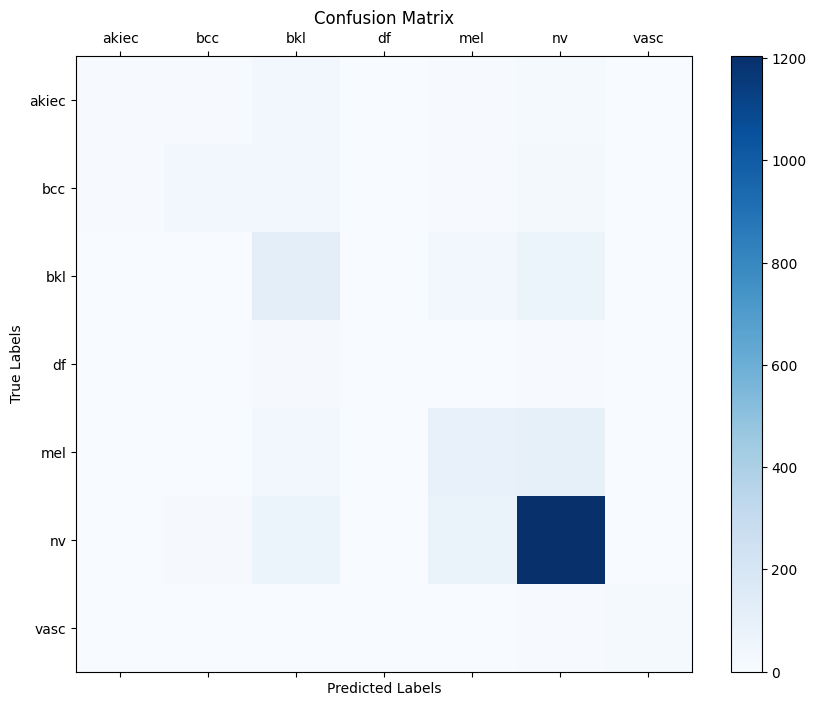

In [21]:
conf_matrix = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + list(label_encoder.keys()))
ax.set_yticklabels([''] + list(label_encoder.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Menampilkan classification report
print(classification_report(test_labels, pred_labels, target_names=label_encoder.keys()))

              precision    recall  f1-score   support

       akiec       0.46      0.09      0.15        66
         bcc       0.60      0.35      0.44       104
         bkl       0.41      0.54      0.47       222
          df       0.67      0.08      0.15        24
         mel       0.40      0.38      0.39       225
          nv       0.85      0.89      0.87      1360
        vasc       0.71      0.54      0.61        28

    accuracy                           0.72      2029
   macro avg       0.59      0.41      0.44      2029
weighted avg       0.72      0.72      0.71      2029



In [23]:
# Menampilkan grafik loss training dan validasi
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Menyimpan model ke file
model.save('model_resnet-152.h5')